# Linear Regression

A simple linear regression model to serve as a benchmark against which the performance of other techniques can be compared. This model will not be optimised.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

In [2]:
matplotlib.rcParams['figure.figsize'] = (16, 9)
pd.options.display.max_columns = 999

## Load Dataset

In [3]:
df = pd.read_csv('../datasets/household-electricity.csv', parse_dates=[0], index_col='DateTime')
print(df.shape)
df.head()

(26305, 321)


,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,ts11,ts12,ts13,ts14,ts15,ts16,ts17,ts18,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28,ts29,ts30,ts31,ts32,ts33,ts34,ts35,ts36,ts37,ts38,ts39,ts40,ts41,ts42,ts43,ts44,ts45,ts46,ts47,ts48,ts49,ts50,ts51,ts52,ts53,ts54,ts55,ts56,ts57,ts58,ts59,ts60,ts61,ts62,ts63,ts64,ts65,ts66,ts67,ts68,ts69,ts70,ts71,ts72,ts73,ts74,ts75,ts76,ts77,ts78,ts79,ts80,ts81,ts82,ts83,ts84,ts85,ts86,ts87,ts88,ts89,ts90,ts91,ts92,ts93,ts94,ts95,ts96,ts97,ts98,ts99,ts100,ts101,ts102,ts103,ts104,ts105,ts106,ts107,ts108,ts109,ts110,ts111,ts112,ts113,ts114,ts115,ts116,ts117,ts118,ts119,ts120,ts121,ts122,ts123,ts124,ts125,ts126,ts127,ts128,ts129,ts130,ts131,ts132,ts133,ts134,ts135,ts136,ts137,ts138,ts139,ts140,ts141,ts142,ts143,ts144,ts145,ts146,ts147,ts148,ts149,ts150,ts151,ts152,ts153,ts154,ts155,ts156,ts157,ts158,ts159,ts160,ts161,ts162,ts163,ts164,ts165,ts166,ts167,ts168,ts169,ts170,ts171,ts172,ts173,ts174,ts175,ts176,ts177,ts178,ts179,ts180,ts181,ts182,ts183,ts184,ts185,ts186,ts187,ts188,ts189,ts190,ts191,ts192,ts193,ts194,ts195,ts196,ts197,ts198,ts199,ts200,ts201,ts202,ts203,ts204,ts205,ts206,ts207,ts208,ts209,ts210,ts211,ts212,ts213,ts214,ts215,ts216,ts217,ts218,ts219,ts220,ts221,ts222,ts223,ts224,ts225,ts226,ts227,ts228,ts229,ts230,ts231,ts232,ts233,ts234,ts235,ts236,ts237,ts238,ts239,ts240,ts241,ts242,ts243,ts244,ts245,ts246,ts247,ts248,ts249,ts250,ts251,ts252,ts253,ts254,ts255,ts256,ts257,ts258,ts259,ts260,ts261,ts262,ts263,ts264,ts265,ts266,ts267,ts268,ts269,ts270,ts271,ts272,ts273,ts274,ts275,ts276,ts277,ts278,ts279,ts280,ts281,ts282,ts283,ts284,ts285,ts286,ts287,ts288,ts289,ts290,ts291,ts292,ts293,ts294,ts295,ts296,ts297,ts298,ts299,ts300,ts301,ts302,ts303,ts304,ts305,ts306,ts307,ts308,ts309,ts310,ts311,ts312,ts313,ts314,ts315,ts316,ts317,ts318,ts319,ts320,ts321
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,12.690355,68.278805,231.972198,412.601626,213.414634,1053.571429,27.133974,838.383838,223.776224,263.440860,177.347243,145.936982,109.125718,169.703872,227.313567,1000.000000,47.738693,160.352423,591.623037,86.550436,31.662269,0.0,883.177570,121.186441,101.096224,423.484119,182.842830,358.552632,0.0,81.703911,447.257384,34.423408,406.189555,345.549738,519.230769,175.349428,4045.454545,149.823322,216.582064,810.426540,110.169492,66.457352,4130.434783,782.918149,182.948490,165.123457,323.149236,276.978417,222.222222,156.234097,126.064736,510.603589,500.438982,124.370594,405.560098,291.286307,135.350318,3974.358974,278.571429,265.563436,680.161943,670.533643,835.443038,214.238190,190.476190,395.494368,117.706237,451.682953,287.671233,288.349515,123.655914,241.234956,129.695252,75.949367,438.502674,156.976744,378.832839,794.303797,596.424010,1831.578947,435.356201,404.444444,1087.301587,50.868486,356.237492,6.091371,27.791814,12.048193,26.086957,294.117647,655.683690,878.90625,36.617843,749.128920,1766.182299,745.762712,600.000000,164.841183,526.490066,331.769437,521.276596,189.801700,325.358852,25.110783,68.163593,453.997809,401.938591,60.527677,426.881720,118.701964,173.062453,1452.560873,609.467456,17.453799,49.773756,503.271538,249.852333,0.0,7951.219512,1011.235955,76.271186,104.039168,219.096334,416.579224,102.428722,422.222222,193.986276,2786.743516,56.122995,77.404215,5540.123457,1084.835631,5188.940092,610.906411,1712.747253,0.0,188.397291,65.417867,516.827795,243.623910,0.0,305.161290,261.661184,136.398010,0.0,225.241810,89.568966,129.733728,0.0,5.219985,59.108138,632.492114,669.794721,2532.374101,859.060403,511.196068,5148.305085,648.054146,26958.333333,239.247312,328.802589,767.201835,1091.409692,444.093493,530.140845,715.053763,1452.238806,824.152542,245.131730,1068.027211,11302.521008,820.3

## Define Parameters

Make predictions for 24-hour period using a training period of four weeks.

In [4]:
dataset_name = 'Household Electricity Consumption'
dataset_abbr = 'HEC'
context_length = 24*7*4 # Four weeks
prediction_length = 24

## Define Error Metric

The seasonal variant of the mean absolute scaled error (MASE) will be used to evaluate the forecasts.

In [5]:
def calc_sMASE(training_series, testing_series, prediction_series, seasonality=prediction_length):
    a = training_series.iloc[seasonality:].values
    b = training_series.iloc[:-seasonality].values
    d = np.sum(np.abs(a-b)) / len(a)
    errors = np.abs(testing_series - prediction_series)
    return np.mean(errors) / d

## Example Linear Regression Model

Functions will be used to readily prepare datasets for each time series.

In [6]:
def select_ts(ts, df=df):
    dft = df.iloc[:, ts-1]
    return dft

In [7]:
def create_features(dft, window=prediction_length):
    dftf = dft.copy()
    dftf = dftf.reset_index()
    # One hot encode day of week
    day_names = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
    for i in range(7):
        dftf[day_names[i]] = (dftf['DateTime'].dt.dayofweek == i).astype(int)

    # One hot encode hour of day
    hour_names = ['hour_%s' % str(i) for i in range(24)]
    for i in range(24):
        dftf[hour_names[i]] = (dftf['DateTime'].dt.hour == i).astype(int)

    # Continuous variable for years
    dftf['annual'] = (dftf['DateTime'] - dftf['DateTime'][0]).dt.days / 365

    # Moving average
    dftf['ma'] = dftf.iloc[:, 1].rolling(window).mean()
    dftf['ma'] = dftf['ma'].shift(window)
    dftf.dropna(inplace=True)
    
    dftf.set_index('DateTime', inplace=True)
    
    return dftf

In [8]:
def split_data(dftf, test_length=prediction_length):
    X_train = dftf.iloc[:-test_length, 1:]
    X_test = dftf.iloc[-test_length:, 1:]

    y_train = dftf.iloc[:-test_length, 0]
    y_test = dftf.iloc[-test_length:, 0]
    
    return X_train, X_test, y_train, y_test

Illustrate model for an example household. Ridge regression is used for regularisation.

In [9]:
from sklearn.linear_model import Ridge

ts = 1
df_ex = select_ts(ts)
df_ex = create_features(df_ex)
X_train, X_test, y_train, y_test = split_data(df_ex)

lr = Ridge()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred[y_pred < 0] = 0
sMASE = calc_sMASE(y_train[-(context_length + prediction_length):-prediction_length], y_test, y_pred)
print("sMASE: {:.4f}".format(sMASE))

sMASE: 1.3639


Plot example predictions.

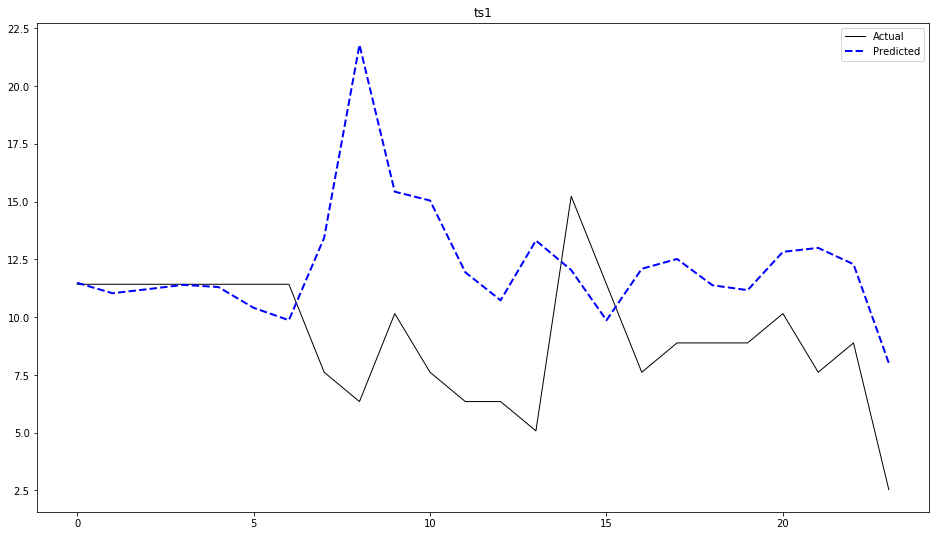

In [10]:
plt.plot(y_test.values, label='Actual', c='k', linewidth=1)
plt.plot(y_pred, label='Predicted', c='b', linestyle='--', linewidth=2)
plt.legend()
plt.title('ts%s' % ts);

Examine example linear regression model coefficients.

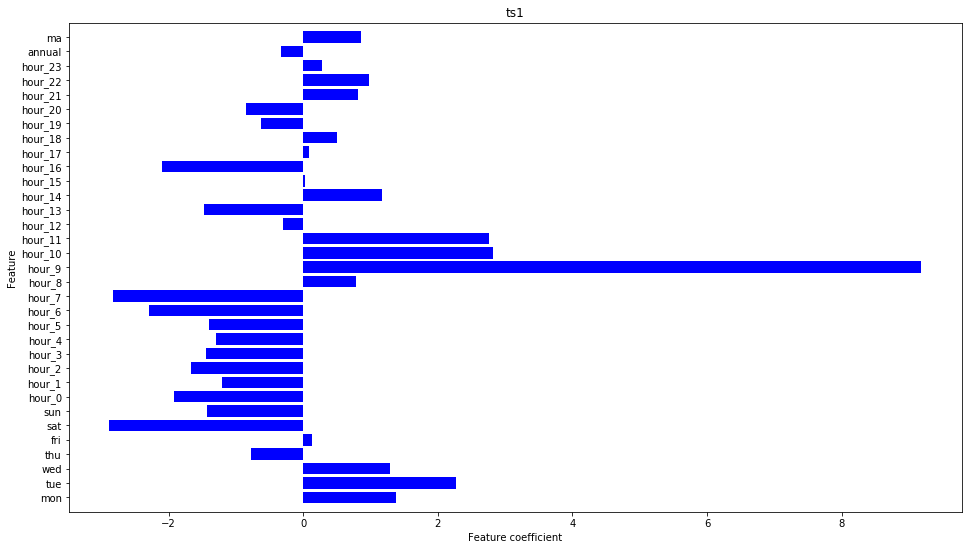

In [11]:
coefs = lr.coef_
cols = df_ex.columns[1:]
params = pd.Series(coefs, index=cols)

fig, ax = plt.subplots()
ax.barh(range(len(params)), params.values, align='center', color='b')
plt.xlabel('Feature coefficient')
plt.yticks(np.arange(len(params)), params.index)
plt.ylabel('Feature')
plt.ylim(-1, len(params))
plt.title('ts%s' % ts);

## Evaluate Linear Regresion

In [12]:
results = df.copy()

for i in range(len(df.columns)):
    ts = i + 1
    dft = select_ts(ts)
    dftf = create_features(dft)
    X_train, X_test, y_train, y_test = split_data(dftf)

    lr = Ridge()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    results['pred%s' % ts] = np.nan
    results['pred%s' % ts].iloc[-prediction_length:] = y_pred

In [13]:
results0 = results.copy()
results0[results0 < 0] = 0

In [14]:
results0.head()

,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,ts11,ts12,ts13,ts14,ts15,ts16,ts17,ts18,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28,ts29,ts30,ts31,ts32,ts33,ts34,ts35,ts36,ts37,ts38,ts39,ts40,ts41,ts42,ts43,ts44,ts45,ts46,ts47,ts48,ts49,ts50,ts51,ts52,ts53,ts54,ts55,ts56,ts57,ts58,ts59,ts60,ts61,ts62,ts63,ts64,ts65,ts66,ts67,ts68,ts69,ts70,ts71,ts72,ts73,ts74,ts75,ts76,ts77,ts78,ts79,ts80,ts81,ts82,ts83,ts84,ts85,ts86,ts87,ts88,ts89,ts90,ts91,ts92,ts93,ts94,ts95,ts96,ts97,ts98,ts99,ts100,ts101,ts102,ts103,ts104,ts105,ts106,ts107,ts108,ts109,ts110,ts111,ts112,ts113,ts114,ts115,ts116,ts117,ts118,ts119,ts120,ts121,ts122,ts123,ts124,ts125,ts126,ts127,ts128,ts129,ts130,ts131,ts132,ts133,ts134,ts135,ts136,ts137,ts138,ts139,ts140,ts141,ts142,ts143,ts144,ts145,ts146,ts147,ts148,ts149,ts150,ts151,ts152,ts153,ts154,ts155,ts156,ts157,ts158,ts159,ts160,ts161,ts162,ts163,ts164,ts165,ts166,ts167,ts168,ts169,ts170,ts171,ts172,ts173,ts174,ts175,ts176,ts177,ts178,ts179,ts180,ts181,ts182,ts183,ts184,ts185,ts186,ts187,ts188,ts189,ts190,ts191,ts192,ts193,ts194,ts195,ts196,ts197,ts198,ts199,ts200,ts201,ts202,ts203,ts204,ts205,ts206,ts207,ts208,ts209,ts210,ts211,ts212,ts213,ts214,ts215,ts216,ts217,ts218,ts219,ts220,ts221,ts222,ts223,ts224,ts225,ts226,ts227,ts228,ts229,ts230,ts231,ts232,ts233,ts234,ts235,ts236,ts237,ts238,ts239,ts240,ts241,ts242,ts243,ts244,ts245,ts246,ts247,ts248,ts249,ts250,ts251,ts252,ts253,ts254,ts255,ts256,ts257,ts258,ts259,ts260,ts261,ts262,ts263,ts264,ts265,ts266,ts267,ts268,ts269,ts270,ts271,ts272,ts273,ts274,ts275,ts276,ts277,ts278,ts279,ts280,ts281,ts282,ts283,ts284,ts285,ts286,ts287,ts288,ts289,ts290,ts291,ts292,ts293,ts294,ts295,ts296,ts297,ts298,ts299,ts300,ts301,ts302,ts303,ts304,ts305,ts306,ts307,ts308,ts309,ts310,ts311,ts312,ts313,ts314,ts315,ts316,ts317,ts318,ts319,ts320,ts321,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,pred10,pred11,pred12,pred13,pred14,pred15,pred16,pred17,pred18,pred19,pred20,pred21,pred22,pred23,pred24,pred25,pred26,pred27,pred28,pred29,pred30,pred31,pred32,pred33,pred34,pred35,pred36,pred37,pred38,pred39,pred40,pred41,pred42,pred43,pred44,pred45,pred46,pred47,pred48,pred49,pred50,pred51,pred52,pred53,pred54,pred55,pred56,pred57,pred58,pred59,pred60,pred61,pred62,pred63,pred64,pred65,pred66,pred67,pred68,pred69,pred70,pred71,pred72,pred73,pred74,pred75,pred76,pred77,pred78,pred79,pred80,pred81,pred82,pred83,pred84,pred85,pred86,pred87,pred88,pred89,pred90,pred91,pred92,pred93,pred94,pred95,pred96,pred97,pred98,pred99,pred100,pred101,pred102,pred103,pred104,pred105,pred106,pred107,pred108,pred109,pred110,pred111,pred112,pred113,pred114,pred115,pred116,pred117,pred118,pred119,pred120,pred121,pred122,pred123,pred124,pred125,pred126,pred127,pred128,pred129,pred130,pred131,pred132,pred133,pred134,pred135,pred136,pred137,pred138,pred139,pred140,pred141,pred142,pred143,pred144,pred145,pred146,pred147,pred148,pred149,pred150,pred151,pred152,pred153,pred154,pred155,pred156,pred157,pred158,pred159,pred160,pred161,pred162,pred163,pred164,pred165,pred166,pred167,pred168,pred169,pred170,pred171,pred172,pred173,pred174,pred175,pred176,pred177,pred178,pred179,pred180,pred181,pred182,pred183,pred184,pred185,pred186,pred187,pred188,pred189,pred190,pred191,pred192,pred193,pred194,pred195,pred196,pred197,pred198,pred199,pred200,pred201,pred202,pred203,pred204,pred205,pred206,pred207,pred208,pred209,pred210,pred211,pred212,pred213,pred214,pred215,pred216,pred217,pred218,pred219,pred220,pred221,pred222,pred223,pred224,pred225,pred226,pred227,pred228,pred229,pred230,pred231,pred232,pred233,pred234,pred235,pred236,pred237,pred238,pred239,pred240,pred241,pred242,pred243,pred244,pred245,pred246,pred247,pred248,pred249,pred250,pred251,pred252,pred253,pred254,pred255,pred256,pred257,pred258,pred259,pred260,pred261,pred262,pred263,pred264,pred265,pred266,pred267,pred268,pred269,pred270,pred271,pred272,pred273,pred274,pred275,pred276,pred277,pred278,pred279,pred280,pred281,pred282,pred283,pred284,pred285,pred286,p

In [15]:
sMASEs = []
for i, col in enumerate(df.columns):
    sMASEs.append(calc_sMASE(results[col].iloc[-(context_length + prediction_length):-prediction_length],
                             results[col].iloc[-prediction_length:],
                             results['pred%s' % str(i+1)].iloc[-prediction_length:]))

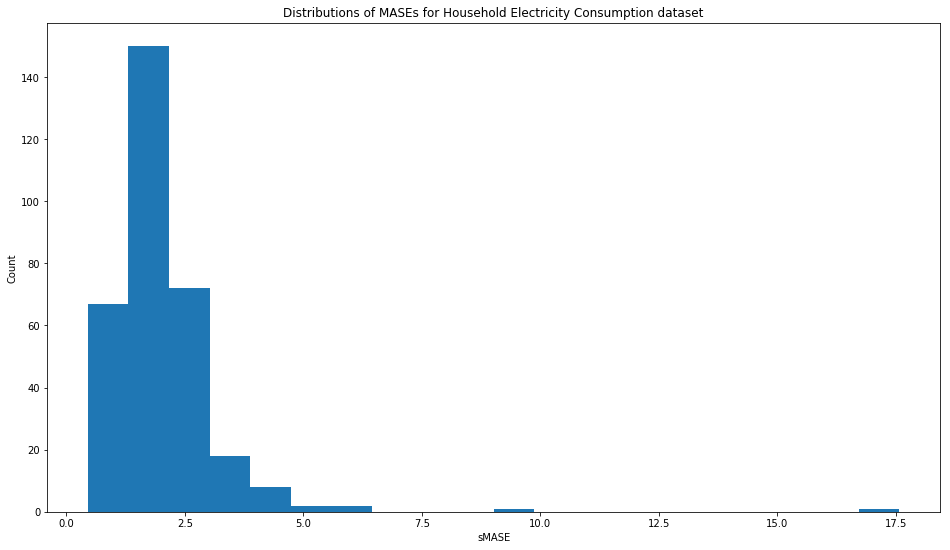

In [16]:
fig, ax = plt.subplots()
ax.hist(sMASEs, bins=20)
ax.set_title('Distributions of MASEs for {} dataset'.format(dataset_name))
ax.set_xlabel('sMASE')
ax.set_ylabel('Count');

In [17]:
sMASE = np.mean(sMASEs)
print("Overall sMASE: {:.4f}".format(sMASE))

Overall sMASE: 2.0379


Show some example forecasts.

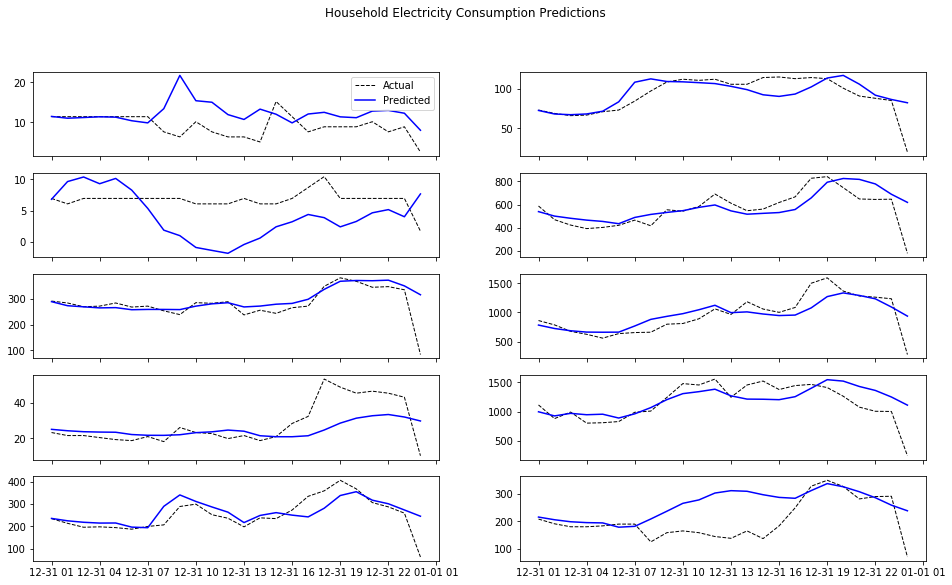

In [18]:
fig, ax = plt.subplots(5, 2, sharex=True)
ax = ax.ravel()

for col in range(1, 11):
    ax[col-1].plot(results.index[-prediction_length:], results['ts%s' % col].iloc[-prediction_length:],
                   label='Actual', c='k', linestyle='--', linewidth=1)
    ax[col-1].plot(results.index[-prediction_length:], results['pred%s' % col].iloc[-prediction_length:],
                   label='Predicted', c='b')
fig.suptitle('{} Predictions'.format(dataset_name))
ax[0].legend();

Store the predictions and accuracy score for the Linear Regression models.

In [19]:
import pickle
    
with open('{}-sMASE.pkl'.format(dataset_abbr), 'wb') as f:
    pickle.dump(sMASE, f)
    
with open('../_results/Naive/{}-results.pkl'.format(dataset_abbr), 'wb') as f:
    pickle.dump(results.iloc[-prediction_length:], f)